## Imports

In [20]:
import sys
import re, numpy as np, pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt

In [2]:
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as pl

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [4]:
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [5]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]
print(df.shape)  #> (2361, 3)
df.head()

(2361, 3)


,content,target,target_names
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
10007,From: jet@netcom.Netcom.COM (J. Eric Townsend)...,8,rec.motorcycles
10008,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,10,rec.sport.hockey
10017,From: nstramer@supergas.dazixco.ingr.com (Naft...,17,talk.politics.mideast
10019,From: mussack@austin.ibm.com (Christopher Muss...,15,soc.religion.christian


## Tokenize Sentences and Clean

In [6]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

[['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', 'organization', 'computrac', 'inc', 'richardson', 'tx', 'keywords', 'ducati', 'gts', 'how', 'much', 'lines', 'have', 'line', 'on', 'ducati', 'gts', 'model', 'with', 'on', 'the', 'clock', 'runs', 'very', 'well', 'paint', 'is', 'the', 'bronze', 'brown', 'orange', 'faded', 'out', 'leaks', 'bit', 'of', 'oil', 'and', 'pops', 'out', 'of', 'st', 'with', 'hard', 'accel', 'the', 'shop', 'will', 'fix', 'trans', 'and', 'oil', 'leak', 'they', 'sold', 'the', 'bike', 'to', 'the', 'and', 'only', 'owner', 'they', 'want', 'and', 'am', 'thinking', 'more', 'like', 'any', 'opinions', 'out', 'there', 'please', 'email', 'me', 'thanks', 'it', 'would', 'be', 'nice', 'stable', 'mate', 'to', 'the', 'beemer', 'then', 'ill', 'get', 'jap', 'bike', 'and', 'call', 'myself', 'axis', 'motors', 'tuba', 'irwin', 'honk', 'therefore', 'am', 'computrac', 'r

## Build the Bigram, Trigram Models and Lemmatize

In [41]:
pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz --no-deps

  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.0-py3-none-any.whl size=12019125 sha256=1fb4c8fb3fcaa5a394a646b4dab4512c712a401885236fc1c1d803eac9403437
  Stored in directory: c:\users\mark s\appdata\local\pip\cache\wheels\64\69\41\6f820cf1d7488a0381a2059f66ec9f8f23116f7c67d18f3d8d
Successfully built en-core-web-sm
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.0.0
    Uninstalling en-core-web-sm-2.0.0:
      Successfully uninstalled en-core-web-sm-2.0.0
Note: you may need to restart the kernel to use updated packages.


In [10]:
nlp=spacy.load('en_core_web_sm')

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
# or do
# !conda install -c conda-forge spacy-model-en_core_web_md 
# and use nlp=spacy.load('en_core_web_sm') instead in below function.
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

## Build the Topic Model

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())
#> [(0,
#>   '0.017*"write" + 0.015*"people" + 0.014*"organization" + 0.014*"article" + '
#>   '0.013*"time" + 0.008*"give" + 0.008*"first" + 0.007*"tell" + 0.007*"new" + '
#>   '0.007*"question"'),
#>  (1,
#>   '0.008*"christian" + 0.008*"believe" + 0.007*"god" + 0.007*"law" + '
#>   '0.006*"state" + 0.006*"israel" + 0.006*"israeli" + 0.005*"exist" + '
#>   '0.005*"way" + 0.004*"bible"'),
#>  (2,
#>   '0.024*"armenian" + 0.012*"bike" + 0.006*"kill" + 0.006*"work" + '
#>   '0.005*"well" + 0.005*"year" + 0.005*"sumgait" + 0.005*"soldier" + '
#>   '0.004*"way" + 0.004*"ride"'),
#>  (3,
#>   '0.019*"team" + 0.019*"game" + 0.013*"hockey" + 0.010*"player" + '
#>   '0.009*"play" + 0.009*"win" + 0.009*"nhl" + 0.009*"year" + 0.009*"hawk" + '
#>   '0.009*"season"')]

[(0,
  '0.024*"bike" + 0.018*"article" + 0.017*"write" + 0.012*"page" + '
  '0.011*"ride" + 0.011*"state" + 0.008*"marriage" + 0.008*"new" + 0.008*"buy" '
  '+ 0.006*"motorcycle"'),
 (1,
  '0.032*"team" + 0.030*"game" + 0.019*"player" + 0.018*"play" + 0.017*"year" '
  '+ 0.015*"season" + 0.013*"hockey" + 0.012*"win" + 0.011*"score" + '
  '0.010*"blue"'),
 (2,
  '0.014*"time" + 0.011*"people" + 0.008*"tell" + 0.007*"write" + 0.006*"look" '
  '+ 0.006*"armenian" + 0.006*"first" + 0.006*"work" + 0.006*"call" + '
  '0.006*"give"'),
 (3,
  '0.010*"question" + 0.010*"people" + 0.010*"believe" + 0.010*"write" + '
  '0.008*"law" + 0.007*"book" + 0.006*"claim" + 0.006*"answer" + 0.006*"give" '
  '+ 0.006*"mean"')]


## Dominant topics and their percentage contribution in each document?

In [17]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.7568,"bike, article, write, page, ride, state, marri...","[summary, worth, expire, keyword, ducati, gts,..."
1,1,2.0,0.8052,"time, people, tell, write, look, armenian, fir...","[insurance, message, service, write, judgement..."
2,2,1.0,0.4683,"team, game, player, play, year, season, hockey...","[reply, write, boy, rip, espns, hockey, covera..."
3,3,0.0,0.4257,"bike, article, write, page, ride, state, marri...","[reply, today, report, yesterday, follow, egyp..."
4,4,3.0,0.5810,"question, people, believe, write, law, book, c...","[question, authority, trendy, liberal, feminis..."
5,5,2.0,0.5965,"time, people, tell, write, look, armenian, fir...","[harrasse, work, prayer, reply, repeat, emphas..."
6,6,2.0,0.9657,"time, people, tell, write, look, armenian, fir...","[ok, apparently, last, post, little, hasy, cal..."
7,7,3.0,0.5181,"question, people, believe, write, law, book, c...","[science, computing, way, look, die, release, ..."
8,8,2.0,0.5441,"time, people, tell, write, look, armenian, fir...","[canadien, write, kind, problem, steal, show, ..."
9,9,1.0,0.6957,"team, game, player, play, year, season, hockey...","[possible, canadian, cadkey_inc, point, team, ..."


## The Most Representative Sentence for Each Topic

In [18]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9469,"bike, article, write, page, ride, state, marriage, new, buy, motorcycle","[goldwe, performance, reply, write, accord, release, cycle, pillion, dog, defecate, much, mystiq..."
1,1.0,0.9924,"team, game, player, play, year, season, hockey, win, score, blue","[result, game, play, organization, keyword, boxscore, nhl, result, game, play, standing, adam, c..."
2,2.0,0.9851,"time, people, tell, write, look, armenian, first, work, call, give","[armenian, cetin, write, problem, tell, follow, story, famous, war, perform, extraordinary, hero..."
3,3.0,0.9837,"question, people, believe, write, law, book, claim, answer, give, mean","[write, basically, prophet, writing, apostle, writing, writing, record, write, peculiar, interpr..."


## Frequency Distribution of Word Counts in Documents

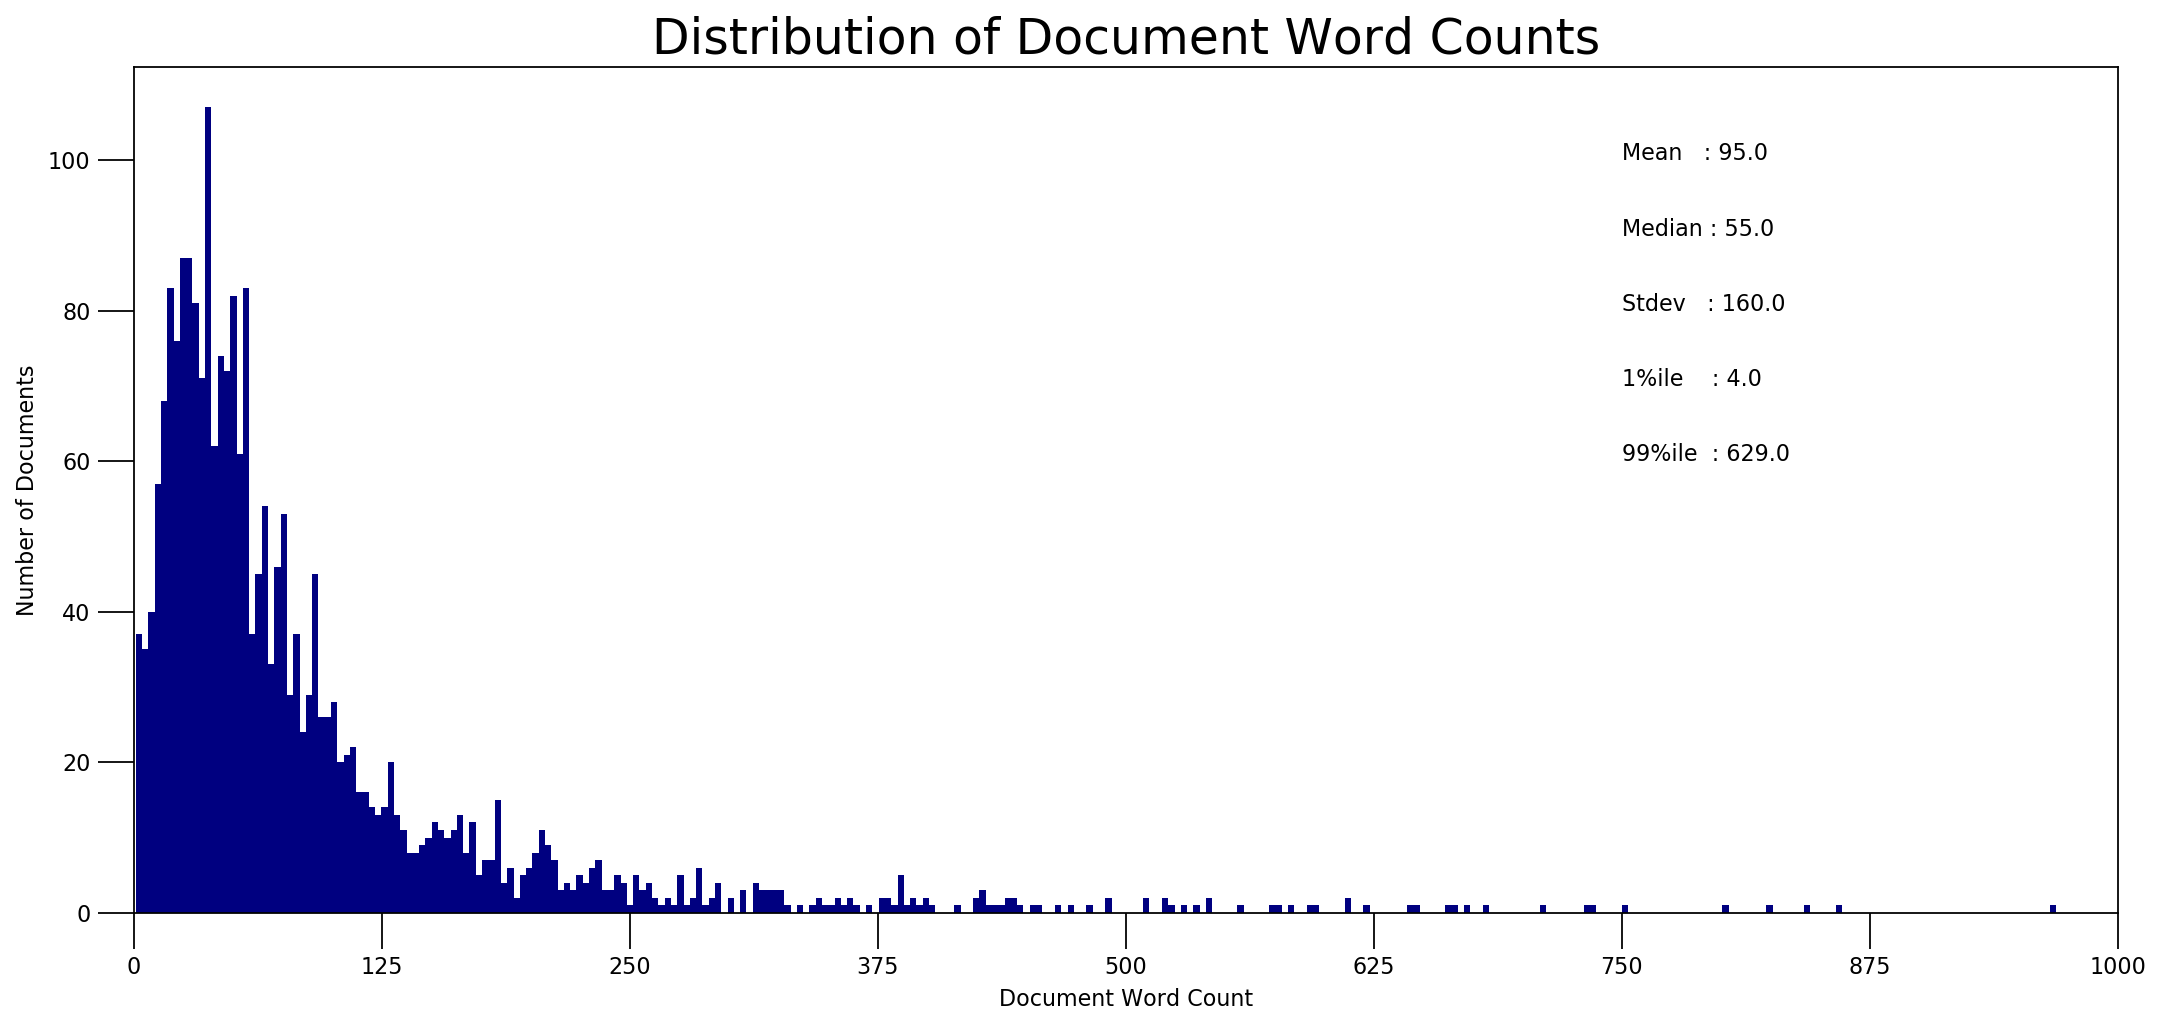

In [21]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

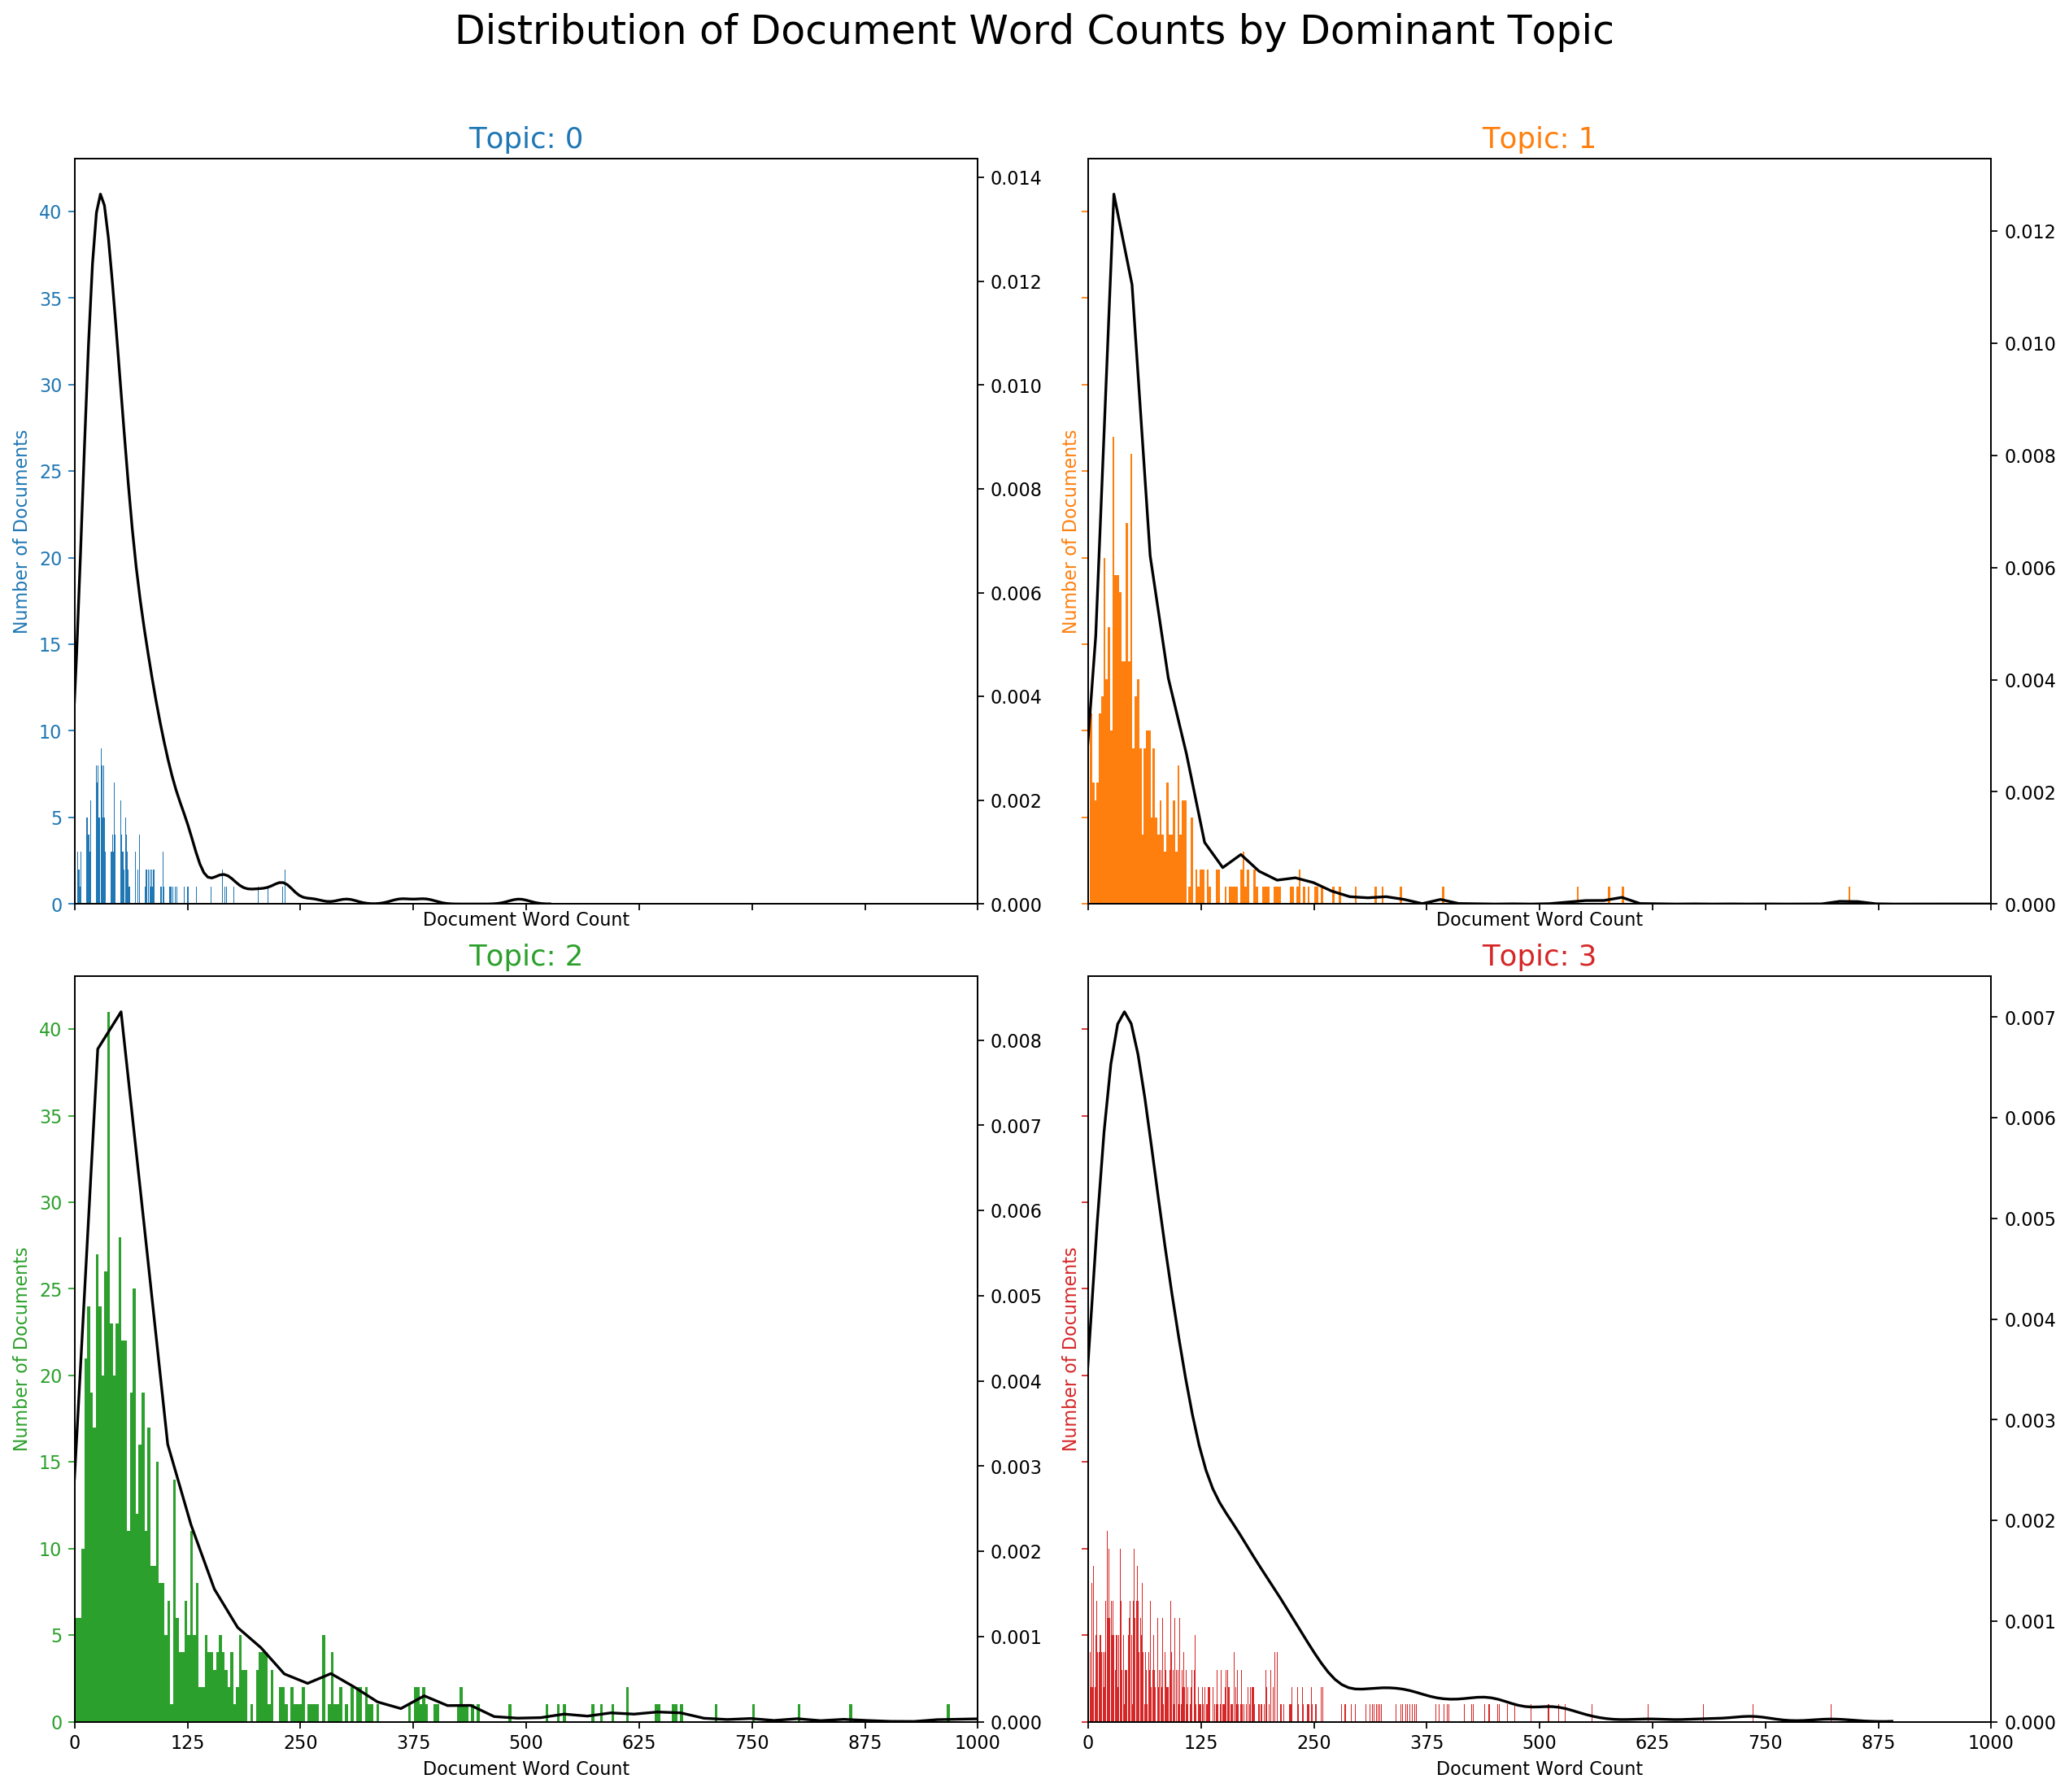

In [22]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

## Word Counts of Topic Keywords

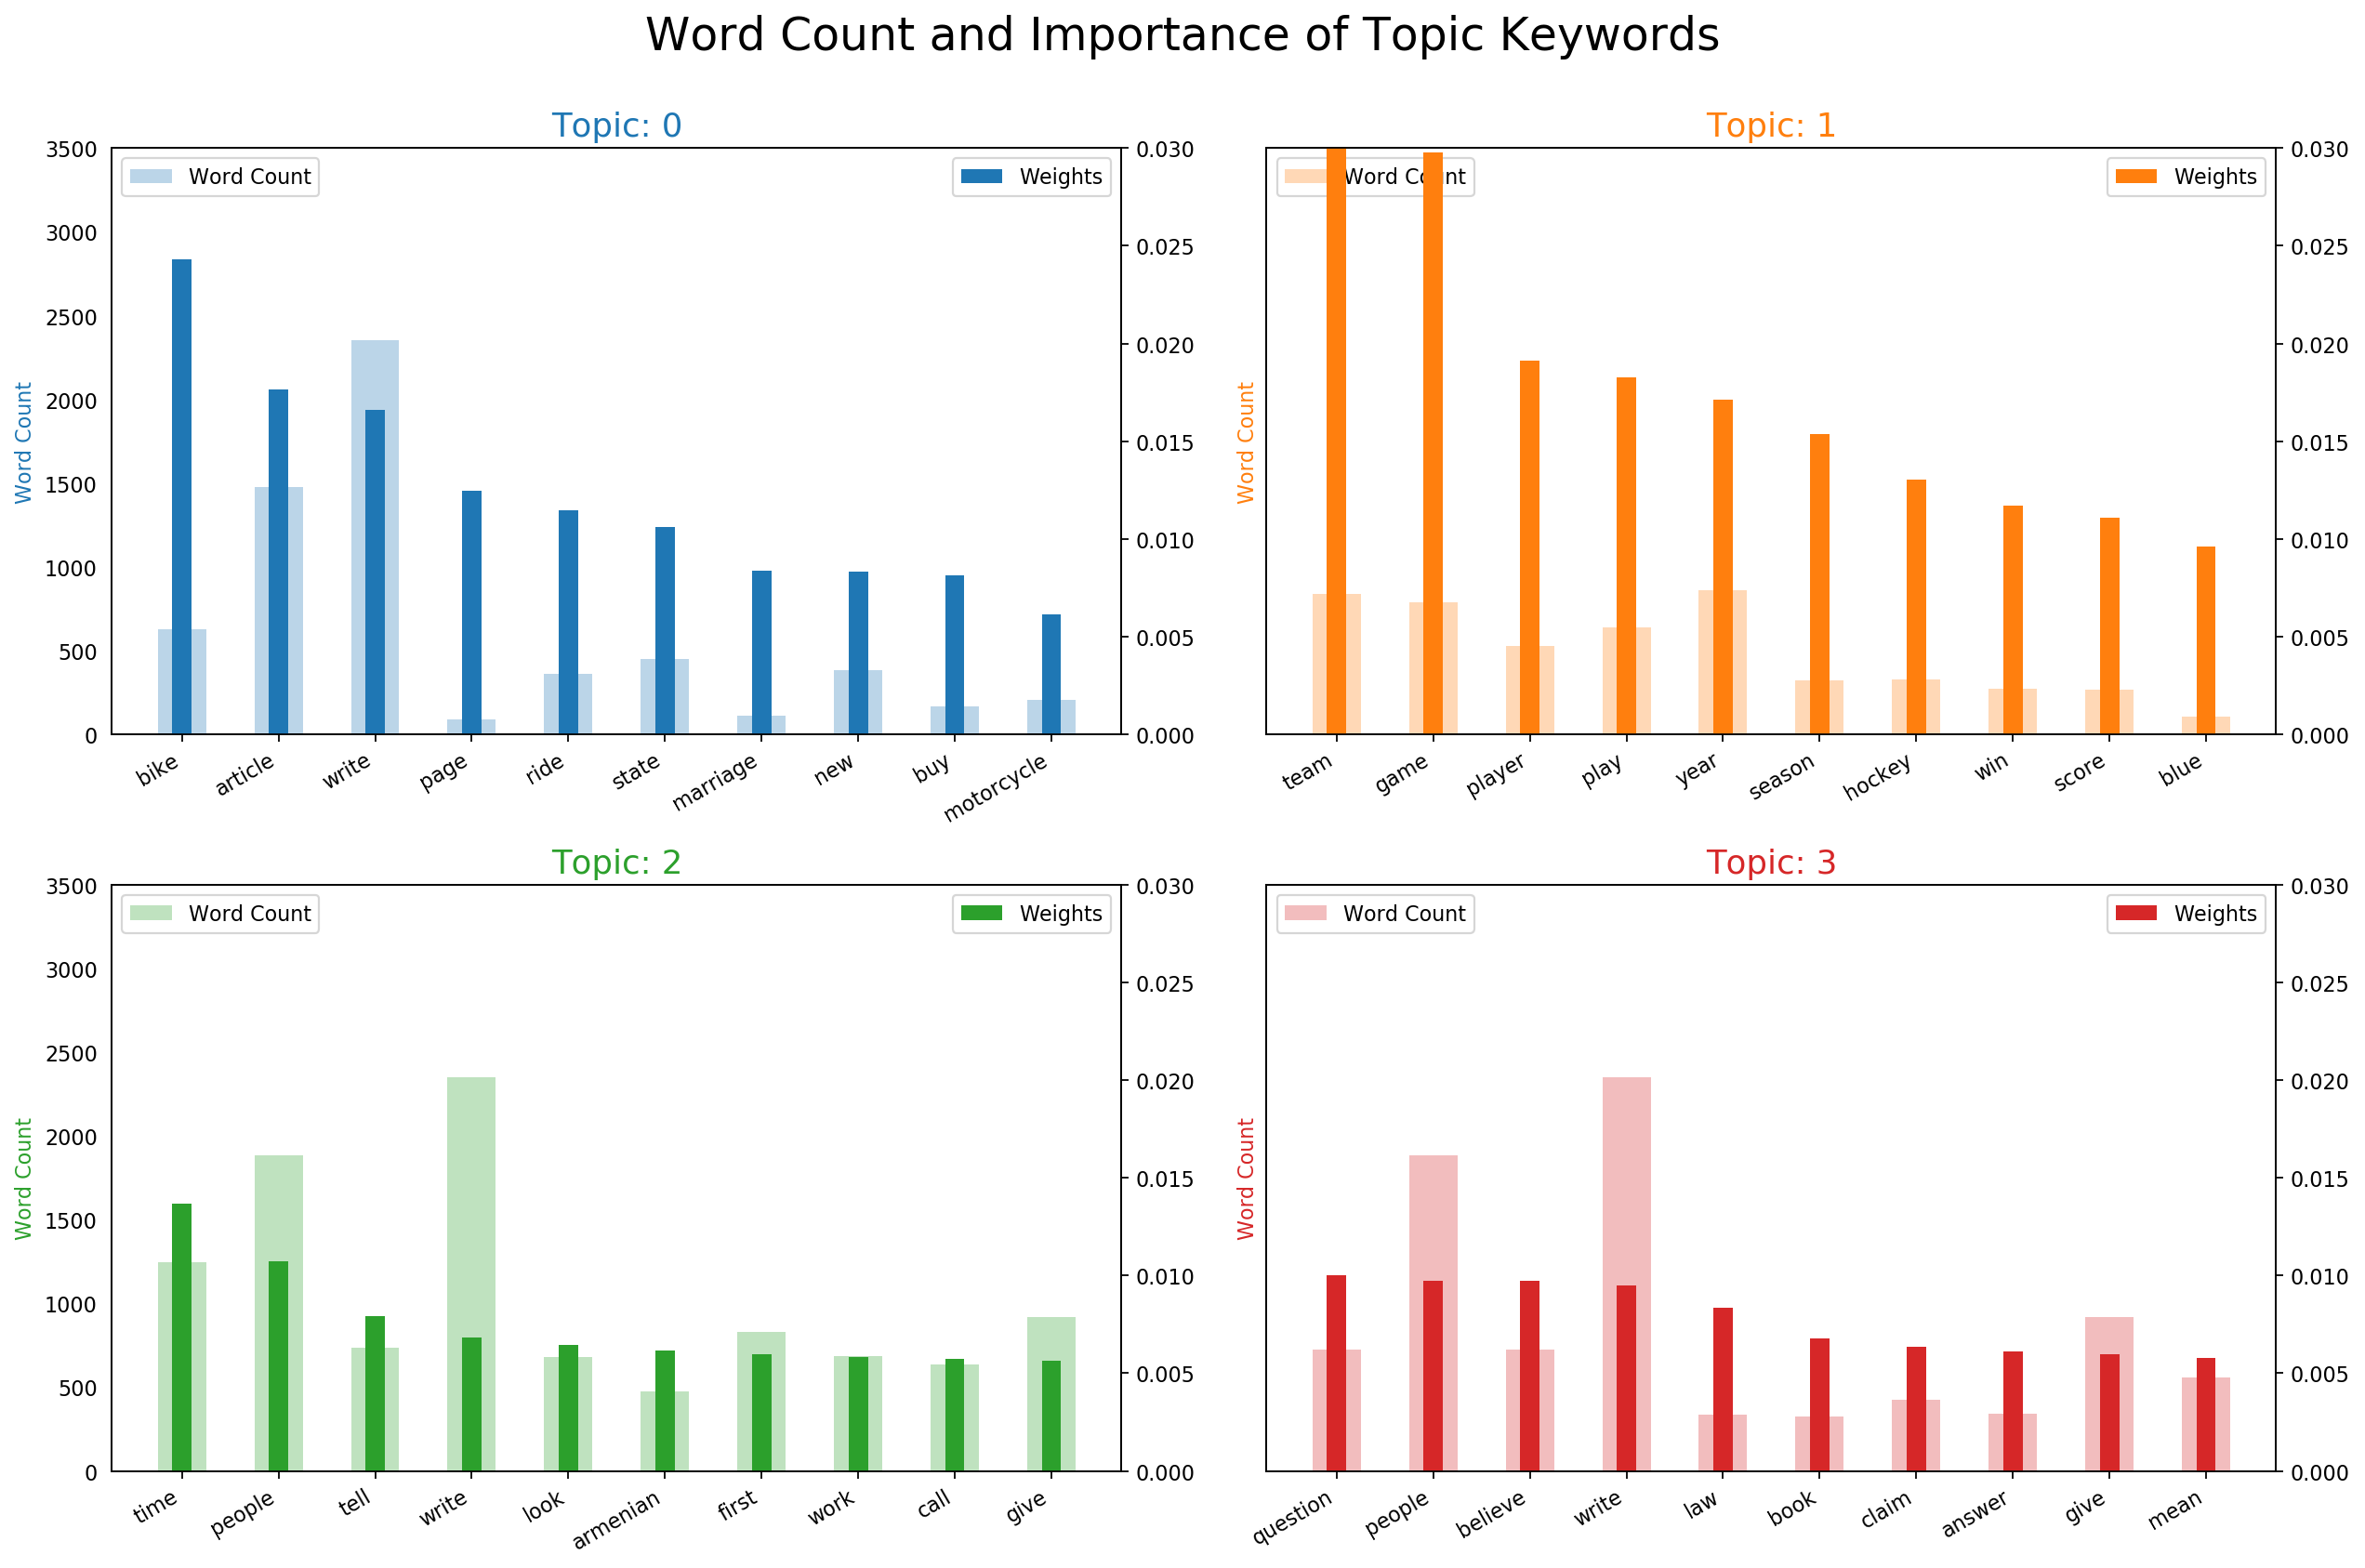

In [23]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## Sentence Chart Colored by Topic

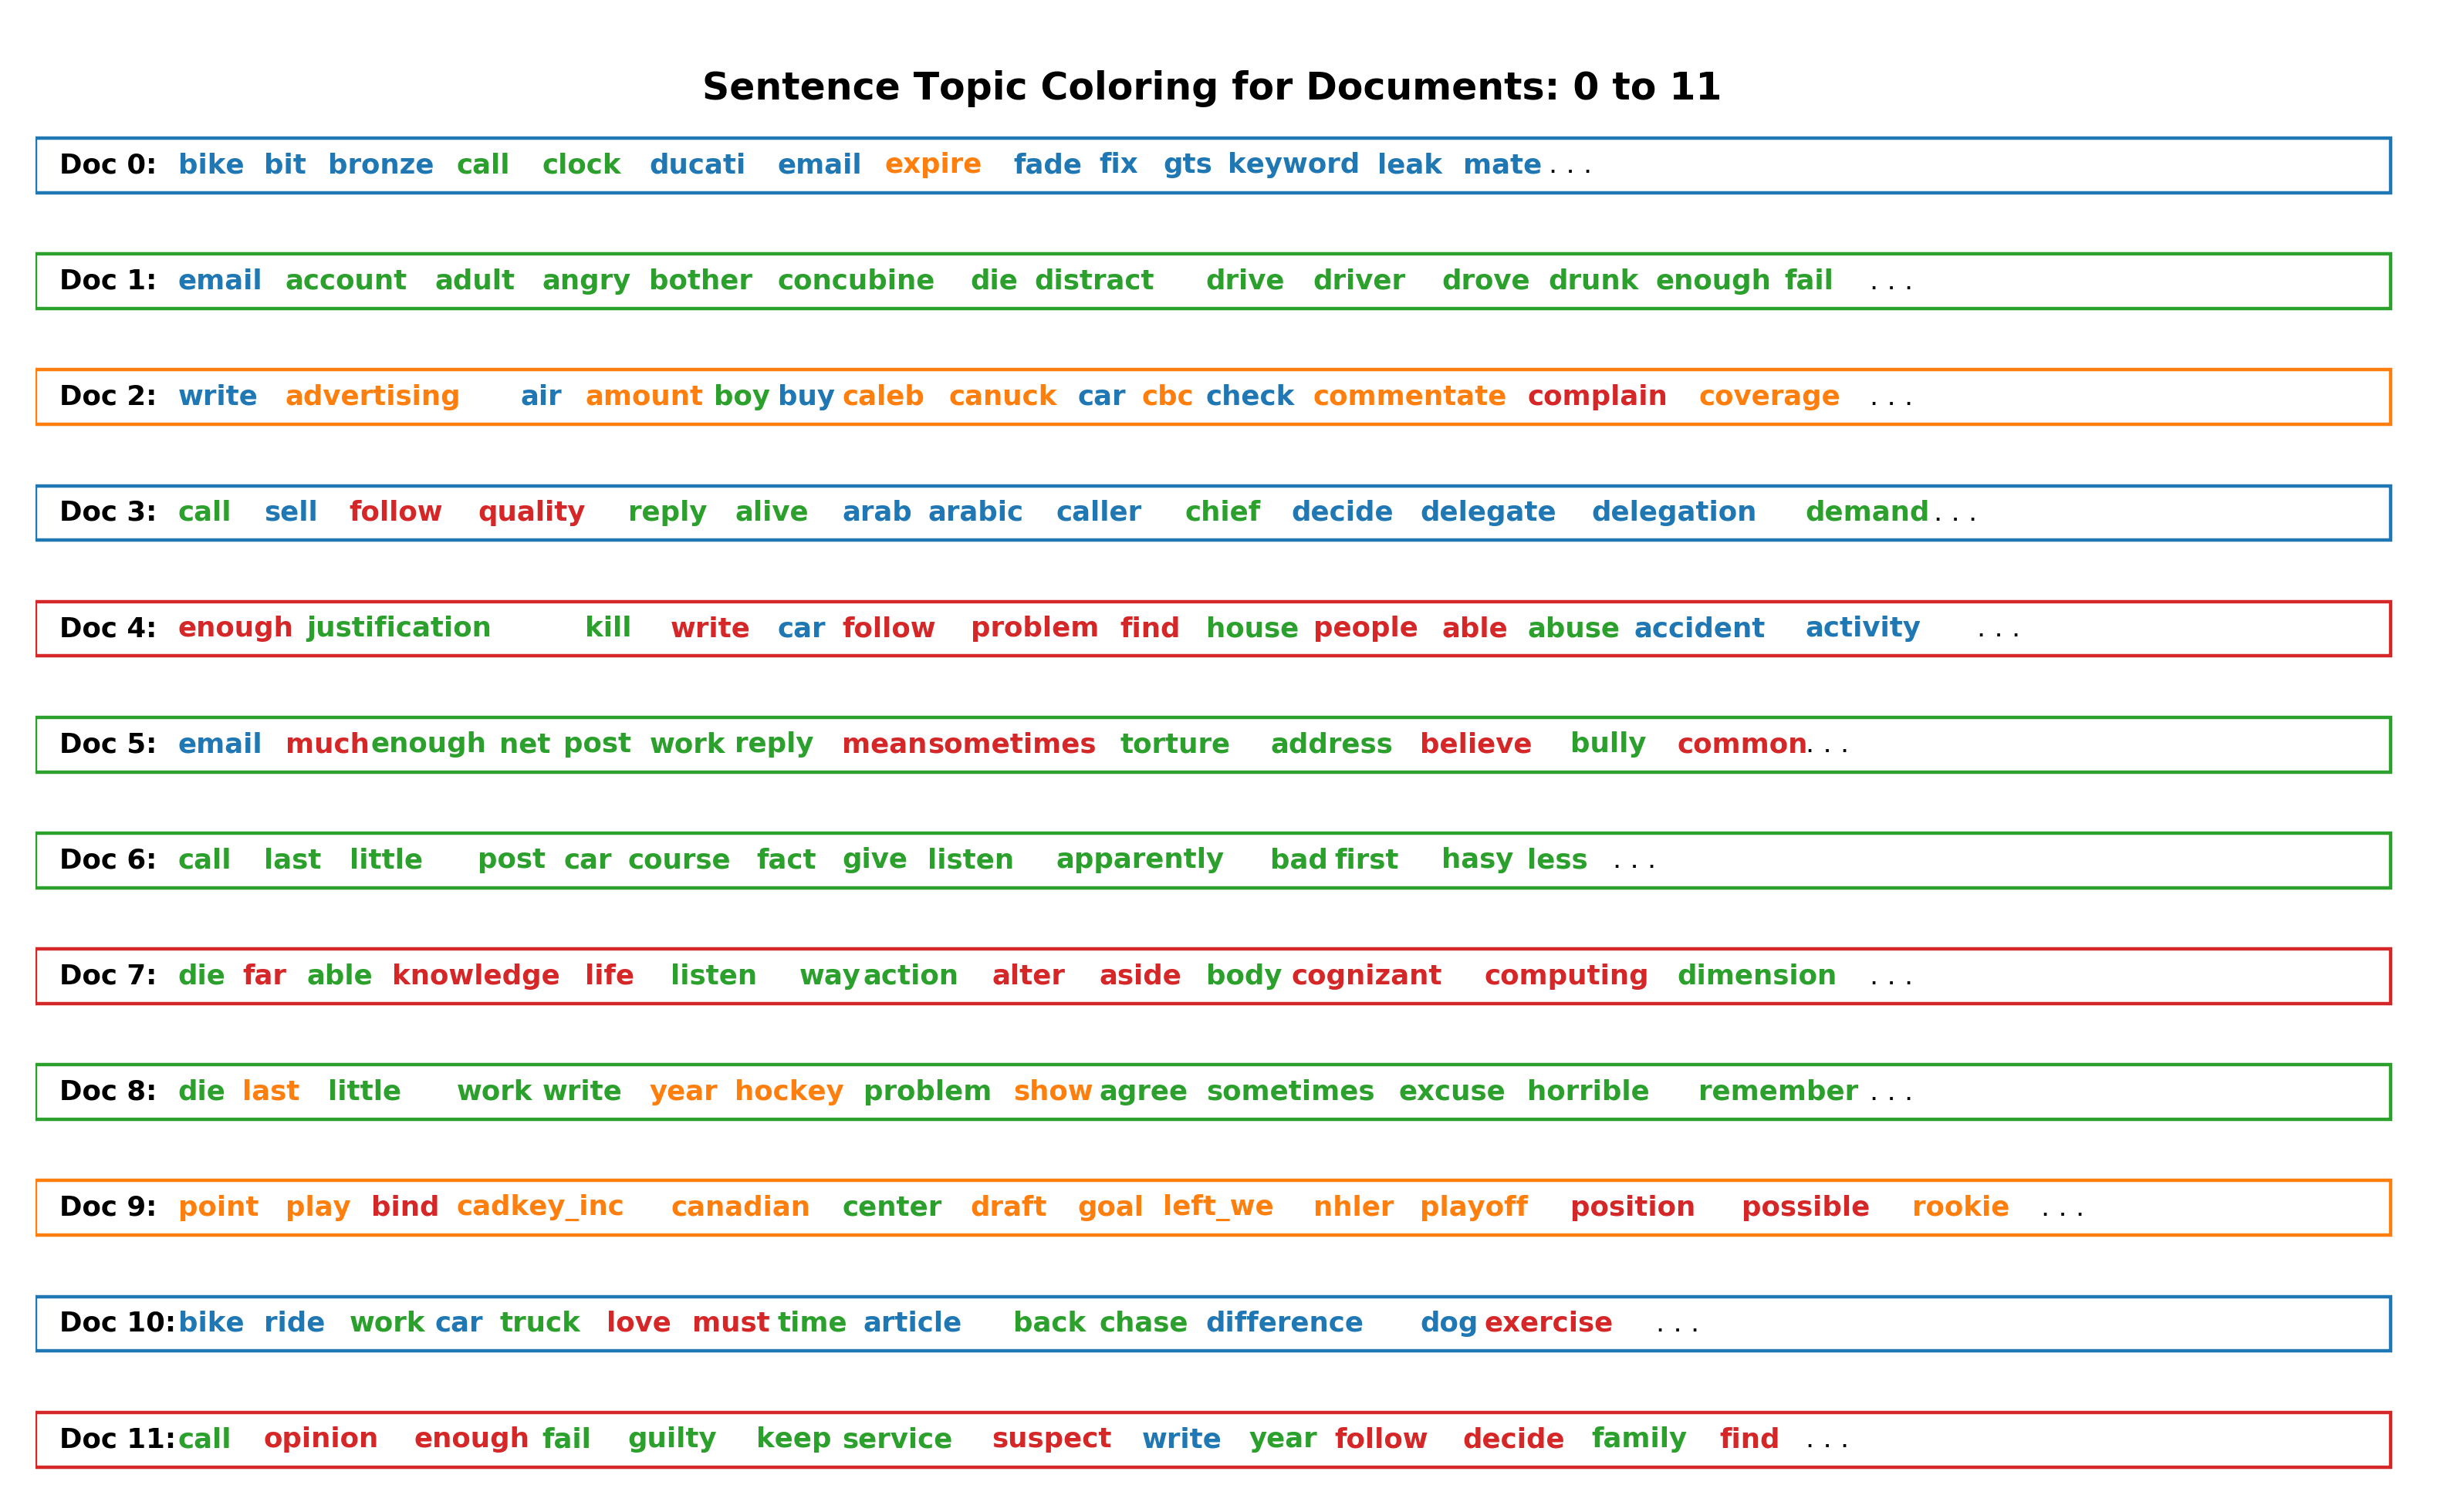

In [24]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

## Most Discussed Topics in the Documents

In [25]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

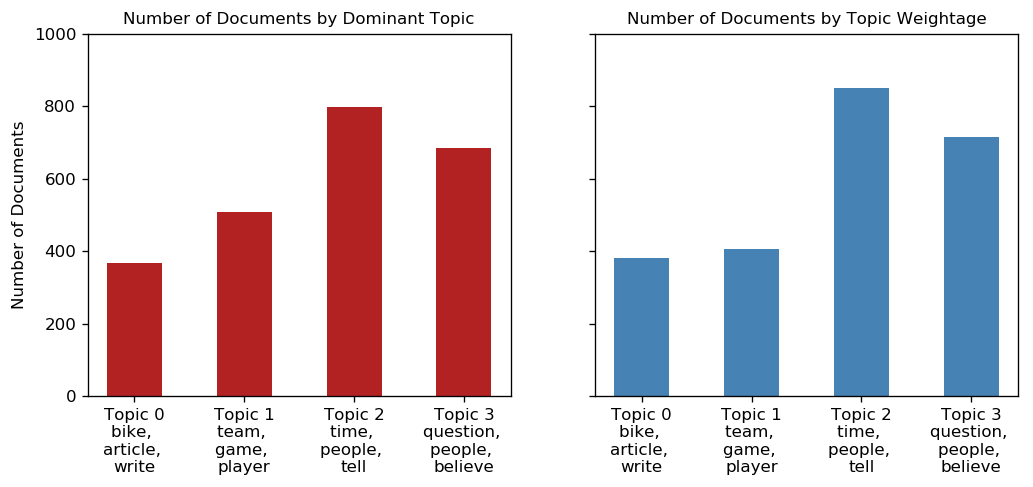

In [26]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

## pyLDAVis

In [28]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

C:\PythonInstall\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.181529  0.069151       1        1  42.086468
3     -0.177353 -0.150771       2        1  33.023705
1      0.114889  0.264140       3        1  12.584342
0      0.243992 -0.182520       4        1  12.305484, topic_info=     Category         Freq         Term        Total  loglift  logprob
411   Default   895.000000         team   895.000000  30.0000  30.0000
912   Default   843.000000         game   843.000000  29.0000  29.0000
0     Default   674.000000         bike   674.000000  28.0000  28.0000
78    Default   960.000000         year   960.000000  27.0000  27.0000
1820  Default   541.000000       player   541.000000  26.0000  26.0000
388   Default   517.000000         play   517.000000  25.0000  25.0000
368   Default  1492.000000         time  1492.000000  24.0000  24.0000
410   Default   435.000000       season   435.000000  23.0000  23.0000
412   Default  1508.000000      article  1508.000000  22.0000  22.0000
287   Default   723.000000      believe   723.000000  21.0000  21.0000
246   Default   754.000000     question   754.000000  20.0000  20.0000
100   Default   369.000000       hockey   369.000000  19.0000  19.0000
161   Default   595.000000        state   595.000000  18.0000  18.0000
2195  Default   348.000000         page   348.000000  17.0000  17.0000
394   Default   331.000000          win   331.000000  16.0000  16.0000
548   Default   621.000000          law   621.000000  15.0000  15.0000
77    Default  2011.000000        write  2011.000000  14.0000  14.0000
64    Default   318.000000         ride   318.000000  13.0000  13.0000
409   Default   315.000000        score   315.000000  12.0000  12.0000
111   Default   635.000000        point   635.000000  11.0000  11.0000
1376  Default   273.000000         blue   273.000000  10.0000  10.0000
844   Default   504.000000         book   504.000000   9.0000   9.0000
402   Default   251.000000         goal   251.000000   8.0000   8.0000
235   Default   518.000000          new   518.000000   7.0000   7.0000
174   Default   454.000000       answer   454.000000   6.0000   6.0000
151   Default  1739.000000       people  1739.000000   5.0000   5.0000
1122  Default   582.000000     armenian   582.000000   4.0000   4.0000
704   Default   232.000000     marriage   232.000000   3.0000   3.0000
83    Default   225.000000          buy   225.000000   2.0000   2.0000
507   Default   428.000000        exist   428.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
990    Topic4   113.670258         file   114.512245   2.0877  -5.4957
2195   Topic4   345.715393         page   348.343018   2.0876  -4.3834
1039   Topic4    96.504128         seat    97.267860   2.0872  -5.6594
150    Topic4    84.366890  palestinian    85.066345   2.0869  -5.7938
2769   Topic4    79.858490        cheap    80.542351   2.0866  -5.8487
3775   Topic4    79.506485         rear    80.234703   2.0860  -5.8531
3908   Topic4    82.903694        store    83.666977   2.0860  -5.8113
1489   Topic4   106.591896         info   107.585159   2.0858  -5.5600
3023   Topic4    73.886826      company    74.621552   2.0852  -5.9264
4072   Topic4    98.560188  negotiation    99.541008   2.0852  -5.6383
570    Topic4    69.243568     official    69.961700   2.0848  -5.9913
152    Topic4    70.680992        phone    71.438866   2.0845  -5.9708
4921   Topic4    73.661247         tank    74.458229   2.0844  -5.9295
1379   Topic4    75.674873       corner    76.503609   2.0842  -5.9025
3748   Topic4    76.482422       advice    77.329605   2.0841  -5.8919
1927   Topic4    70.264130         card    71.048019   2.0840  -5.9767
258    Topic4   101.973030         site   103.315872   2.0820  -5.6043
4212   Topic4   146.498398         seal   149.824554   2.0727  -5.2420
440    Topic4    88.321373       affair    90.510384   2.0706  -5.7480
481    Topic